In [334]:
import pylab as pl
import openturns as ot
import openturns.viewer as otv
from openturns.usecases import flood_model

from matplotlib import pylab as plt
import numpy as np
import scipy.stats as scs 

In [335]:
def plotDistributionGridPDF(distribution):
    """
    Plot the marginal and bi-dimensional iso-PDF on a grid.

    Parameters
    ----------
    distribution : ot.Distribution
        The distribution.

    Returns
    -------
    grid : ot.GridLayout(dimension, dimension)
        The grid of plots.

    """
    dimension = distribution.getDimension()
    grid = ot.GridLayout(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                distributionI = distribution.getMarginal([i])
                graph = distributionI.drawPDF()
            else:
                distributionJI = distribution.getMarginal([j, i])
                graph = distributionJI.drawPDF()
            graph.setLegends([""])
            graph.setTitle("")
            if i < dimension - 1:
                graph.setXTitle("")
            if j > 0:
                graph.setYTitle("")
            grid.setGraph(i, j, graph)
    grid.setTitle("Iso-PDF values")
    return grid

In [336]:
# INPUT

# Observation

paramDim = 2
obsSize = 50
thetaTrue = [9.81, 41.56]
stdobs = 2

errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = stdobs ** 2

# Input 

xmin = 0.0
xmax = 3.0

step = (xmax - xmin) / (obsSize - 1)
rg = ot.RegularGrid(xmin, step, obsSize)
x_obs = rg.getVertices()

# Prior and calibration input

thetaPriorMean = [7, 45] # Mean Prior
sigma0 = [3.0, 3.0]  # standard Deviations

stdg = sigma0[0]
stdh0 = sigma0[1]

sigma = ot.CovarianceMatrix(2)
sigma[0, 0] = stdg ** 2
sigma[1, 1] = stdh0 ** 2

In [337]:
# OBSERVATION

balldropg_true = ot.SymbolicFunction(
    ["t", "g", "h0"], ["max(-g * 0.5 * t^2 + h0,0)", "1.0"]
)

linkFunction = ot.ParametricFunction(balldropg_true, [0], [1.0])

noise = ot.Normal(0, stdobs)
noiseSample = noise.getSample(obsSize)

y_obs = ot.Sample(obsSize, 1)
for i in range(obsSize):
    linkFunction.setParameter(x_obs[i])
    y_obs[i, 0] = linkFunction(thetaTrue)[0] + noiseSample[i, 0]

print(linkFunction)

ParametricEvaluation([t,g,h0]->[max(-g * 0.5 * t^2 + h0,0),1.0], parameters positions=[0], parameters=[t : 3], input positions=[1,2])


In [338]:
# BLAXBOX MODEL

def balldropg(X):
    t, g, h0 = X
    h =  max(-g * 0.5 * t**2 + h0,0)
    return [h]

f = ot.PythonFunction(3, 1, balldropg)
f = ot.MemoizeFunction(f)
f.setInputDescription(["t", "g", "h0"])
f.setOutputDescription(["h"])

cgf = ot.ParametricFunction(f, [1, 2], thetaTrue)

print(cgf)

ParametricEvaluation(MemoizeEvaluation(class=PythonEvaluation name=OpenTURNSPythonFunction), parameters positions=[1,2], parameters=[g : 9.81, h0 : 41.56], input positions=[0])


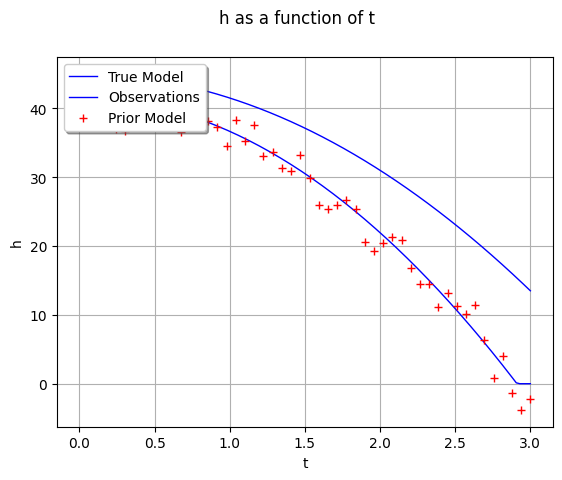

In [339]:
graphModel1 = cgf.getMarginal(0).draw(xmin, xmax)

priorgraph = ot.ParametricFunction(f, [1, 2], thetaPriorMean).getMarginal(0).draw(xmin, xmax)
observations = ot.Cloud(x_obs, y_obs)
observations.setColor("red")

graphModel1.add(priorgraph)
graphModel1.add(observations)
graphModel1.setLegends(["True Model", "Observations", "Prior Model"])
graphModel1.setLegendPosition("topleft")
view = otv.View(graphModel1)

In [340]:
conditional = ot.Normal()
thetaPriorCovarianceMatrix = ot.CovarianceMatrix(paramDim)

for i in range(paramDim):
    thetaPriorCovarianceMatrix[i, i] = sigma0[i] ** 2

prior = ot.Normal(thetaPriorMean, thetaPriorCovarianceMatrix)
prior.setDescription(["g", "h0"])
proposal = ot.Uniform(-1.0, 1.0)

In [341]:
# Gibbs algo
sampleSize = 10000

# Metropolis-Hastings Sampler

initialState = thetaPriorMean

# We create a RandomWalkMetropolisHastings sampler for each component. Each sampler must be aware of the joint prior distribution

mh_coll = [
    ot.RandomWalkMetropolisHastings(prior, initialState, proposal, [i])
    for i in range(paramDim)
]

# Each sampler must be made aware of the likelihood

for mh in mh_coll:
    mh.setLikelihood(conditional, y_obs, linkFunction, x_obs)

# the Gibbs algorithm is constructed from all Metropolis-Hastings samplers

sampler = ot.Gibbs(mh_coll)
sample = sampler.getSample(sampleSize)

gcali, h0cali = np.mean(sample[:,0]), np.mean(sample[:,1])

[mh.getAcceptanceRate() for mh in sampler.getMetropolisHastingsCollection()]

[0.2311, 0.3514]

9.753852118665879 41.02318759924688


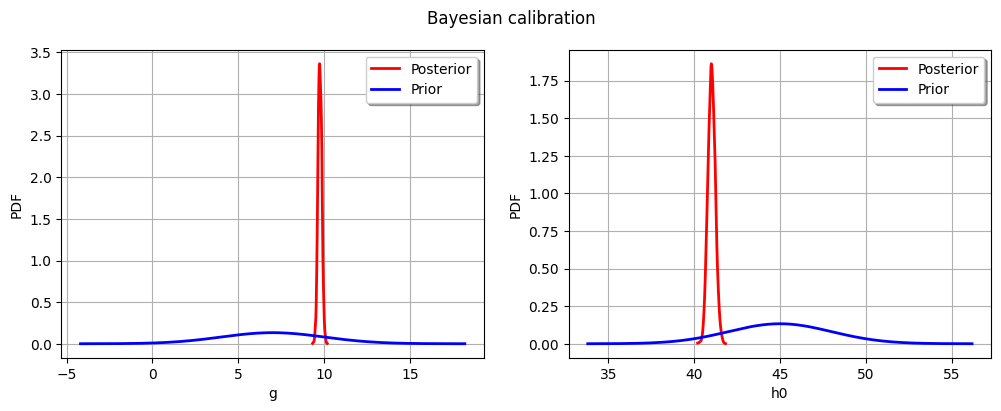

In [342]:
# Build the distribution of the posterior by kernel smoothing

print(gcali, h0cali)

kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

fig = pl.figure(figsize=(12, 4))

for parameter_index in range(paramDim):
    graph = posterior.getMarginal(parameter_index).drawPDF()
    priorGraph = prior.getMarginal(parameter_index).drawPDF()
    priorGraph.setColors(["blue"])
    graph.add(priorGraph)
    graph.setLegends(["Posterior", "Prior"])
    ax = fig.add_subplot(1, paramDim, parameter_index + 1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")

plt.show()


In [343]:
type_algo = 'NLLS'

# LinearLeastSquaresCalibration

if type_algo == 'LLS':
    algo = ot.LinearLeastSquaresCalibration(cgf, x_obs, y_obs, thetaPriorMean)

# NonLinearLeastSquaresCalibration

if type_algo == 'NLLS':
    algo = ot.NonLinearLeastSquaresCalibration(cgf, x_obs, y_obs, thetaPriorMean)

# Gaussian linear calibration
"""
The GaussianLinearCalibration class performs the Gaussian linear calibration by linearizing the model in the neighbourhood of the prior. 
This is also known as the Kalman filter.
"""
if type_algo == 'LGP':
    algo = ot.GaussianLinearCalibration(
        cgf, x_obs, y_obs, thetaPriorMean, sigma, errorCovariance
    )

# Gaussian nonlinear calibration
"""
This algorithm is also known as 3DVar
"""
if type_algo == 'NLGP':
    algo = ot.GaussianNonLinearCalibration(
        cgf, x_obs, y_obs, thetaPriorMean, sigma, errorCovariance
    )

In [344]:
algo.run()
calibrationResult = algo.getResult()
thetaMAP = calibrationResult.getParameterMAP()

print(thetaMAP)

[9.7415,40.9882]


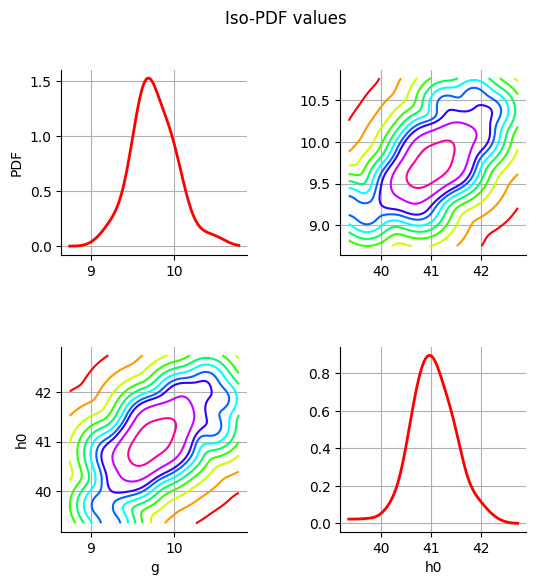

In [345]:
# Plot the PDF values of the distribution of the optimum parameters

thetaPosterior = calibrationResult.getParameterPosterior()

grid = plotDistributionGridPDF(thetaPosterior)
view = otv.View(
    grid,
    figure_kw={"figsize": (6.0, 6.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
plot_space = 0.5
plt.subplots_adjust(wspace=plot_space, hspace=plot_space)

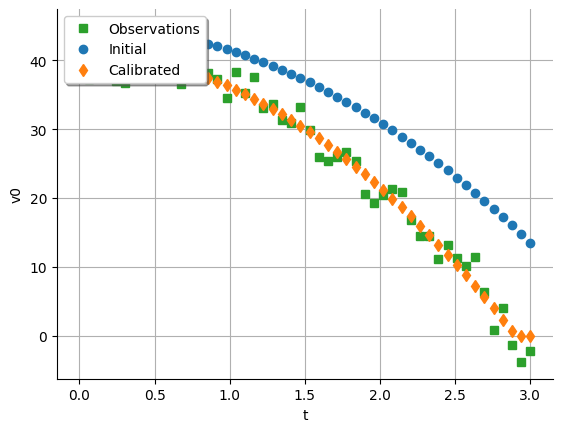

In [346]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
view = otv.View(graph)